In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# configure logging
import logging
logging.basicConfig(level=logging.WARNING)
logging.getLogger('Assignment1MicroarrayEpigeneticClock').setLevel(logging.DEBUG)
logging.getLogger('GlmNetEpigeneticClockTrainer').setLevel(logging.DEBUG)
logging.getLogger('download_file').setLevel(logging.DEBUG)

In [2]:
import os
from epigenetic_clock_assignment import download_file

data_dir = 'data/assignment1'
features_filepath = os.path.join(data_dir, 'GSE40279_average_beta.txt')
features_gz_filepath = os.path.join(data_dir, 'GSE40279_average_beta.txt.gz')

# download features file if does not exists
download_file(url='https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE40279&format=file&file=GSE40279%5Faverage%5Fbeta%2Etxt%2Egz',
             out_filepath=features_filepath, intermediate_gzip_filepath=features_gz_filepath)


DEBUG:download_file:file data/assignment1/GSE40279_average_beta.txt already exists; do not download again


In [3]:
%%time

import os
from epigenetic_clock_assignment import Assignment1MicroarrayEpigeneticClock, GlmNetEpigeneticClockTrainer

data_source = Assignment1MicroarrayEpigeneticClock(
        meta_filepath=os.path.join(data_dir, 'GSE40279_family.soft-MetaData.csv'),
        features_filepath=features_filepath
)

X, y = data_source.load()


DEBUG:Assignment1MicroarrayEpigeneticClock:load
DEBUG:Assignment1MicroarrayEpigeneticClock:joining based on ID
DEBUG:Assignment1MicroarrayEpigeneticClock:loaded


CPU times: user 13.5 s, sys: 1.13 s, total: 14.7 s
Wall time: 14.7 s


In [18]:
from epigenetic_clock_assignment import GlmNetEpigeneticClockTrainer

clock_trainer = GlmNetEpigeneticClockTrainer(
    n_parallel_jobs=2,
    n_cv_fold=3,
    # the weight of standard error used to determine lambda_best, 0 means use lambda_max (see glmnet.ElasticNet)
    std_error_weight_for_lambda_best=0.5,
    seed=42
)

X_train, X_test, y_train, y_test = clock_trainer.train_test_split(X, y, test_size=0.2)

hyperparameter_stats = clock_trainer.hyperparameter_optimization(X_train=X_train, y_train=y_train, alpha_count=10 + 1)


DEBUG:GlmNetEpigeneticClockTrainer:starting hyperparameter optimization with alpha range [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.0...
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   17.7s finished
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.1...
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   13.2s finished
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.2...
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   12.9s finished
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.30000000000000004...
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   12.8s finished
D

BEST lambda        3.980116
alpha         0.100000
cv_r2_mean    0.882437
cv_r2_std     0.020454
Name: 37, dtype: float64


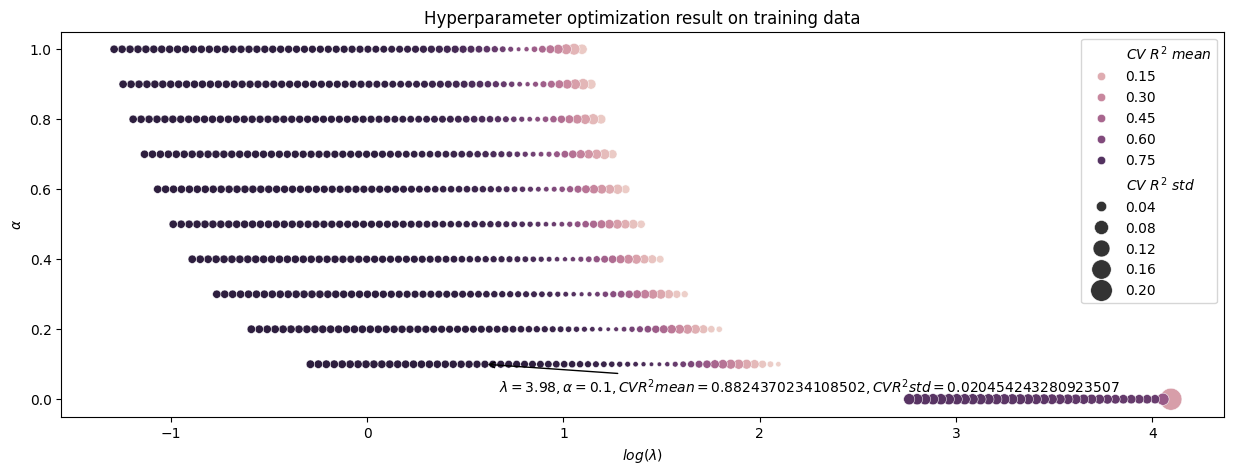

,lambda,alpha,cv_r2_mean,cv_r2_std
0,12440.711242,0.0,0.204970,0.207524
1,11335.512743,0.0,0.512513,0.057642
2,10328.497033,0.0,0.676166,0.030495
3,9410.941823,0.0,0.679888,0.031493
4,8574.899689,0.0,0.684258,0.031190
...,...,...,...,...
55,0.074580,1.0,0.872709,0.023073
56,0.067955,1.0,0.872621,0.023046
57,0.061918,1.0,0.872584,0.023028
58,0.056417,1.0,0.872584,0.023028


In [69]:
clock_trainer.plot_hypterparameter_optimization_result(hyperparameter_stats)
hyperparameter_stats